# RBM for MNIST Digit Classification
## Gabriele Marino

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## RBM Implementation

In [2]:
class RBM():
    
    def __init__(self, n_visible, n_hidden):
        
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.M = np.random.rand(n_visible, n_hidden)
        self.visible_bias = np.zeros(n_visible)
        self.hidden_bias = np.zeros(n_hidden)


    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))


    def train(self, data, test_data=None, learning_rate=1, epochs=100, evaluation_period=1, history=True, errors_filename=None):
        
        n_samples = data.shape[0]
        
        training_errors = []
        if test_data is not None:
            test_errors = []

        for epoch in range(1, epochs + 1):
            
            # ---------- CD-1 ----------
            
            # Wake phase
            v0_state = data
            h0_activation = np.dot(v0_state, self.M) + self.hidden_bias
            h0_probabilities = self.sigmoid(h0_activation)
            h0_state = h0_probabilities > np.random.rand(n_samples, self.n_hidden)
            vh0 = np.dot(v0_state.T, h0_probabilities)

            # Dream phase
            v1_activation = np.dot(h0_state, self.M.T) + self.visible_bias
            v1_probabilities = self.sigmoid(v1_activation)
            v1_state = v1_probabilities > np.random.rand(n_samples, self.n_visible)
            h1_activation = np.dot(v1_state, self.M) + self.hidden_bias
            h1_probabilities = self.sigmoid(h1_activation)
            vh1 = np.dot(v1_state.T, h1_probabilities)
            
            # Weights Update
            self.M += learning_rate * (vh0 - vh1) / n_samples
            self.visible_bias += learning_rate * np.sum(v0_state - v1_state, axis=0) / n_samples
            self.hidden_bias += learning_rate * np.sum(h0_probabilities - h1_probabilities, axis=0) / n_samples
            
            # --------------------------
            
            # Evaluation
            if not epoch % evaluation_period:
                training_error = self.compute_reconstruction_error(data)
                training_errors.append(training_error)
                if test_data is not None:
                    test_error = self.compute_reconstruction_error(test_data)
                    test_errors.append(test_error)
                if history:
                    print(f"Epoch: {epoch} -> Training error: {training_error}" + f"\t\tValidation error: {test_error}" if test_data is not None else "") 
        
        if errors_filename is not None:
            if test_data is not None:
                np.savez(errors_filename, training_errors=training_errors, test_errors=test_errors)
            else:
                np.save(errors_filename, training_errors)
            

    def encode(self, data):
        
        hidden_activation = np.dot(data, self.M) + self.hidden_bias
        hidden_probabilities = self.sigmoid(hidden_activation)
        encoded_data = hidden_probabilities > np.random.rand(data.shape[0], self.n_hidden)

        return encoded_data

    
    def decode(self, encoded_data):

        visible_activation = np.dot(encoded_data, self.M.T) + self.visible_bias
        visible_probabilities = self.sigmoid(visible_activation)
        decoded_data = visible_probabilities > np.random.rand(encoded_data.shape[0], self.n_visible)
        
        return decoded_data
    
    
    def compute_reconstruction_error(self, data):
        
        encoded_data = self.encode(data)
        reconstructed_data = self.decode(encoded_data)
        
        return np.mean(np.sum(np.square(data - reconstructed_data), axis=1))


    def save(self, filename):
        
        np.savez(filename, n_visible=self.n_visible, n_hidden=self.n_hidden, M=self.M, visible_bias=self.visible_bias, hidden_bias=self.hidden_bias)

    
def load_RBM(filename):

    parameters = np.load(filename)
    rbm = RBM(parameters["n_visible"], parameters["n_hidden"])
    rbm.M = parameters["M"]
    rbm.visible_bias = parameters["visible_bias"]
    rbm.hidden_bias = parameters["hidden_bias"]
    return rbm

## RBM Training

### Dataset Loading and Preprocessing

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# The training images are converted to binary arrays by applying a threshold to the value of each of their pixels

X_train = X_train.reshape(X_train.shape[0], -1)
X_train = np.where(X_train < 128, 0, 1)

X_test = X_test.reshape(X_test.shape[0], -1)
X_test = np.where(X_test < 128, 0, 1)

### RBM Building and Training

In [4]:
n_visible = X_train.shape[1]
n_hidden = 100

In [ ]:
rbm = RBM(n_visible, n_hidden)
rbm.train(X_train, X_test, epochs=7000, errors_filename="models/rbm_errors.npz", evaluation_period=10)
rbm.save("models/rbm.npz")

### Reconstruction Error

For visualization purposes the reconstruction errors are plotted with respect to the epochs of training.

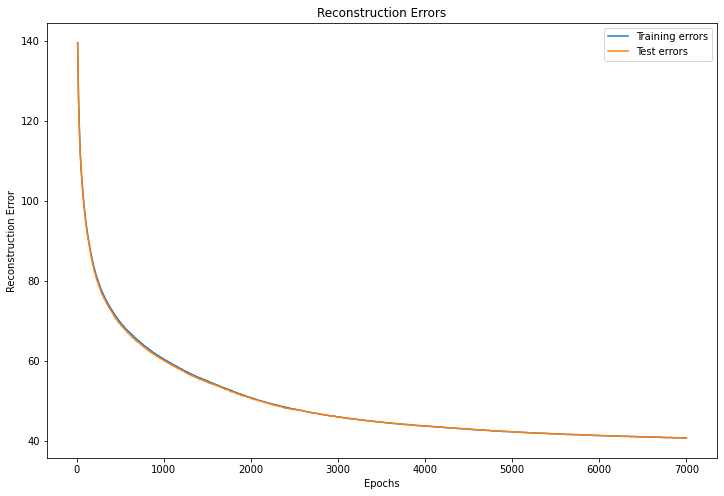

In [5]:
reconstruction_errors = np.load("models/rbm_errors.npz")
training_errors = reconstruction_errors["training_errors"]
test_errors = reconstruction_errors["test_errors"]

plt.figure(figsize=(12,8))
plt.plot(np.arange(1, len(training_errors) + 1) * 10, training_errors, label="Training errors")
plt.plot(np.arange(1, len(test_errors) + 1) * 10, test_errors, label="Test errors")
plt.title("Reconstruction Errors")
plt.xlabel("Epochs")
plt.ylabel("Reconstruction Error")
plt.legend()

plt.show()

Some of the reconstructed images are shown below for visualization purposes

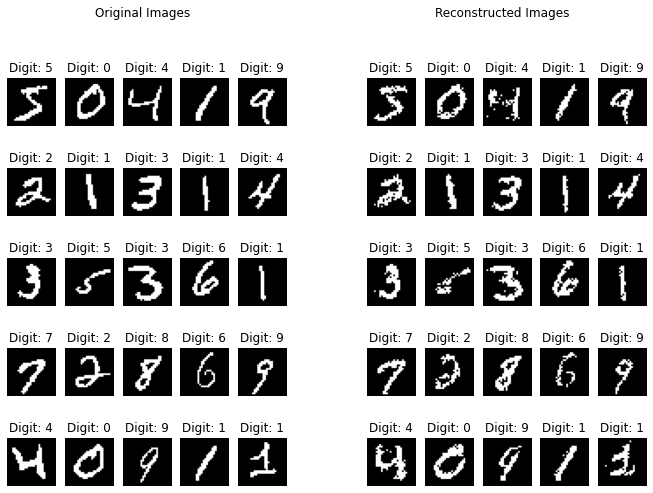

In [7]:
fig = plt.figure(figsize=(10,8))

subfigs = fig.subfigures(1, 2)

subfig = subfigs[0]
subfig.suptitle(f"Original Images")
axes = subfig.subplots(5, 5)
for i, axis in enumerate(axes.flat):
    axis.set_title(f"Digit: {y_train[i]}")
    axis.imshow(X_train[i].reshape(28, 28), cmap="gray")
    axis.axis("off")

rbm = load_RBM("models/rbm.npz")
subfig = subfigs[1]
subfig.suptitle(f"Reconstructed Images")
axes = subfig.subplots(5, 5)
for i, axis in enumerate(axes.flat):
    axis.set_title(f"Digit: {y_train[i]}")
    axis.imshow(rbm.decode(rbm.encode(X_train[i:i+1])).reshape(28, 28), cmap="gray")
    axis.axis("off")

plt.show()

## MNIST Digit Classification

#### Encoding of the dataset

In [8]:
rbm = load_RBM("models/rbm.npz")

X_train_encoded = rbm.encode(X_train)
y_train = to_categorical(y_train)

X_test_encoded = rbm.encode(X_test)
y_test = to_categorical(y_test)

#### Classifier building

A simple MLP with one hidden layer is used as classifier.

In [37]:
model = Sequential()
model.add(Dense(100, activation="relu"))
model.add(Dense(75, activation="relu"))
model.add(Dense(10, activation="softmax"))
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_encoded, y_train, epochs=10, verbose=True)
model.save(f"models/MLP.h5")

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3431 - accuracy: 0.8957
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1834 - accuracy: 0.9427
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1455 - accuracy: 0.9545
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1248 - accuracy: 0.9602
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1095 - accuracy: 0.9646
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0980 - accuracy: 0.9680
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0900 - accuracy: 0.9702
Epoch 8/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0805 - accuracy: 0.9732
Epoch 9/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0723 - accuracy: 0.9762
Epoch 10/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.066

#### Classifier Testing

In [38]:
model = load_model("models/MLP.h5")
loss, accuracy = model.evaluate(X_test_encoded, y_test, verbose=False)
print("Test Loss: {:.4f}".format(loss))
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

Test Loss: 0.1372
Test Accuracy: 95.90%


## Comments and Results

The implementation of the RBM class was straightforward: I followed closely what we learned during the lectures and did not encounter any particular difficulty.  
I chose 100 hidden units for the RBM as it seemed to me a sufficiently high number to represent the complexity of the dataset. Maybe, even a smaller number of hidden units could have been a good choice, but I sticked to 100 to be sure to capture all the relevant features of my data. The training of the RBM required a little time (about 5 hours), but eventually the results looked great: the learning curve was smooth and the reconstruction seemed to work quite well.  
The MNIST handwritten digit classification problem has been solved by models whose accuracies are around 99%. The accuracy obtained by the MLP used in this analysis is a bit lower (95.90%), but this is a good compromise with the save in space given by the RBM encoding of the dataset (each image was compressed from 28x28 = 784 gray scale pixels to 100 binary pixels).  
I really enjoyed this project, which I found very instructive and funny. In particular, I loved getting acquainted with this new type of neural networks as it allowed me to dive deep into probabilistic models in general.